# Genetic Algorithms with DEAP

Source: [Kevin Sikorski](https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/genetic-algorithms-with-deap.ipynb)

In this lab, we will first learn how to use a simple and easy-to-use implementation of a Genetic Algorithm using DEAP library in Python.
Then you'll write code that optimised position in artificial landscapes, use GA on a simple neuralnet to control a game, and use Hebbian Learning to implement simple logic gates.

# Terminology

### Individual
Genetic Algorithms make use of an analogy to genetics, where we use a population of randomly generated individuals, each with some genetic code.  This code represents a potential solution to the problem.  The representation of the solution depends on the particular problem we are addressing, but it generally consists of a data structure.  It could contain one or more strings like "ACGTCACTCGGATGC" if we are dealing with DNA, real-valued data if we are dealing with vectors, arbitrary and mutually-exclusive concepts like "January", "February", and "December", or anything else.

### Fitness
Since these solutions are chosen at random, some are better than others.  We need to be able to evaluate how good a particular solution is.  We do this by defining a fitness function (called an evaluation function in the example below).  This takes in an individual or its genetic code, and outputs a scalar number that allows us to compare fitness between individuals.

### Mutation
In the real world, genetic code mutates due to random events like cosmic rays and nuclear decay, or due to random transcription errors.  We simulate this in genetic algorithms with a mutation rate.  Here with a low probability, we randomly change one or more elements of the genetic code of an individual.  This might be changing a number encoded in it (either a little or a lot), flipping a bit in a string, or randomizing the month in a date-time field.

### Crossover
In the real world, mating between individuals produces offspring with genetic code that is a combination of the parents.  This is simulated with crossover.  In the first diagram below we show two parents at the top, each with different genetic material.  Two offspring are shown below, each the product of crossover.  The parent's genetic code is broken at a randomly selected point.  The right half of the red parent is attached to the left half of the blue parent to produce one offspring's genes; the remaining pieces are similarly concatenated to make the other offspring's genes.

Geometrically, you can think of crossover as a projection of one parent's genetic code to a random plane in the search space that contains the other parent's genetic code.  (This plane will also be aligned with one of the basis vectors of the genetic code.)  The Crossover as projection diagram below shows an example involving two parents in magenta with genetic code (0,0) and (1,1).  When crossover occurs, we produce the cyan individuals with genetic code (0,1) and (1,0) by taking the first element from one parent and the second element from the second parent.  Or phrased geometrically, by projecting one parent's point to the Y-axis (the basis vector for the second element of the genetic code), and the the other parent's point to the X-axis.

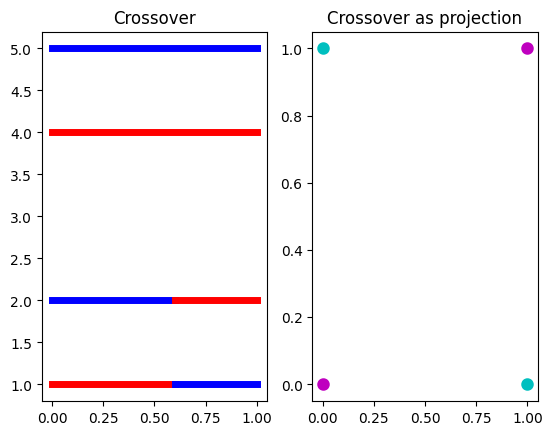

In [1]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title("Crossover")
fig=plt.plot((0, 1), (5, 5), linewidth=5, color='b')
fig=plt.plot((0, 1), (4, 4), linewidth=5, color='r')
fig=plt.plot((0, 0.6), (2, 2), linewidth=5, color='b')
fig=plt.plot((0, 0.6), (1, 1), linewidth=5, color='r')
fig=plt.plot((0.6, 1), (1, 1), linewidth=5, color='b')
fig=plt.plot((0.6, 1), (2, 2), linewidth=5, color='r')

plt.subplot(1,2,2)
plt.scatter([0, 1], [0,1], color='m', lw=3)
plt.scatter([1, 0], [0,1], color='c', lw=3)
plt.title("Crossover as projection")

plt.show()

# One Max Problem
This example will help new users to overview some of the DEAP framework’s possibilities and illustrate the potential of evolutionary algorithms in general. The problem itself is both very simple and widely used in the evolutionary computational community. We will create a population of individuals consisting of integer vectors randomly filled with 0 and 1. Then we let our population evolve until one of its members contains only 1 and no 0 anymore.


In [2]:
import random

!pip install deap
from deap import base
from deap import creator
from deap import tools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.9 MB/s eta 0:00:00


## Creator
Since the actual structure of the required individuals in genetic algorithms does strongly depend on the task at hand, DEAP does not contain any explicit structure. It will rather provide a convenient method for creating containers of attributes, associated with fitnesses, called the deap.creator. Using this method we can create custom individuals in a very simple way.

The creator is a class factory that can build new classes at run-time. It will be called with first the desired name of the new class, second the base class it will inherit, and in addition any subsequent arguments you want to become attributes of your class. This allows us to build new and complex structures of any type of container from lists to n-ary trees.

In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

First we will define the class FitnessMax. It will inherit the Fitness class of the deap.base module and contain an additional attribute called weights. Please mind the value of weights to be the tuple (1.0,). This way we will be maximizing a single objective fitness. We can’t repeat it enough, in DEAP single objectives is a special case of multi objectives.

Next we will create the class Individual, which will inherit the class list and contain our previously defined FitnessMax class in its fitness attribute. Note that upon creation all our defined classes will be part of the creator container and can be called directly.

## Toolbox
Now we will use our custom classes to create types representing our individuals as well as our whole population.

All the objects we will use on our way, an individual, the population, as well as all functions, operators, and arguments will be stored in a DEAP container called Toolbox. It contains two methods for adding and removing content, register() and unregister().

In [4]:
toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual,
    toolbox.attr_bool, 100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In this code block we register a generation function toolbox.attr_bool() and two initialization ones individual() and population(). toolbox.attr_bool(), when called, will draw a random integer between 0 and 1. The two initializers, on the other hand, will instantiate an individual or population.

The registration of the tools to the toolbox only associates aliases to the already existing functions and freezes part of their arguments. This allows us to fix an arbitrary amount of argument at certain values so we only have to specify the remaining ones when calling the method. For example, the attr_bool() generator is made from the randint() function that takes two arguments a and b, with a <= n <= b, where n is the returned integer. Here, we fix a = 0 and b = 1.

Our individuals will be generated using the function initRepeat(). Its first argument is a container class, in our example the Individual one we defined in the previous section. This container will be filled using the method attr_bool(), provided as second argument, and will contain 100 integers, as specified using the third argument. When called, the individual() method will thus return an individual initialized with what would be returned by calling the attr_bool() method 100 times. Finally, the population() method uses the same paradigm, but we don’t fix the number of individuals that it should contain.

## The Evaluation Function
The evaluation function is pretty simple in our example. We just need to count the number of ones in an individual.

In [5]:
def evalOneMax(individual):
    return sum(individual),

print(evalOneMax([0,0,0,0]))
print(evalOneMax([0,1,0,1]))
print(evalOneMax([1,1,1,1]))


(0,)
(2,)
(4,)


## The Genetic Operators
Within DEAP there are two ways of using operators. We can either simply call a function from the tools module or register it with its arguments in a toolbox, as we have already seen for our initialization methods. The most convenient way, however, is to register them in the toolbox, because this allows us to easily switch between the operators if desired. The toolbox method is also used when working with the algorithms module. See the [One Max Problem: Short Version](https://deap.readthedocs.io/en/master/examples/ga_onemax_short.html#short-ga-onemax) for an example.

Registering the genetic operators required for the evolution in our One Max problem and their default arguments in the toolbox is done as follows.

In [6]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

The evaluation will be performed by calling the alias evaluate. It is important to not fix its argument in here. We will need it later on to apply the function to each separate individual in our population. The mutation, on the other hand, needs an argument to be fixed (the independent probability of each attribute to be mutated indpb).

## Evolving the Population
Once the representation and the genetic operators are chosen, we will define an algorithm combining all the individual parts and performing the evolution of our population until the One Max problem is solved.

## Creating the Population
First of all, we need to actually instantiate our population. But this step is effortlessly done using the population() method we registered in our toolbox earlier on.

In [7]:
pop = toolbox.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit


**pop** will be a list composed of 300 individuals. Since we left the parameter **n** open during the registration of the population() method in our toolbox, we are free to create populations of arbitrary size.

Before we go on, this is the time to define some constants we will use later on.

In [8]:
# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.2

## Evaluating the Population
The next thing to do is to evaluate our brand new population.  We map() the evaluation function to every individual and then assign their respective fitness. Note that the order in fitnesses and population is the same.

The evolution of the population is the final step we have to accomplish. Recall, our individuals consist of 100 integer numbers and we want to evolve our population until we got at least one individual consisting of only 1s and no 0s. So all we have to do is to obtain the fitness values of the individuals!

To check the performance of the evolution, we will calculate and print the minimal, maximal, and mean values of the fitnesses of all individuals in our population as well as their standard deviations.

In [9]:
def findFitness():
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    return fits

fits=findFitness()

  Min 38.0
  Max 63.0
  Avg 50.346666666666664
  Std 4.7770097573924035


## Mating and Mutation

In genetic algorithms, evolution occurs via either mutation or crossover, both of which happen (or don't happen) randomly.  In mutation, we change one or more of the genes of one of our individuals.  In cross-over, two individuals are mated to mix their genes.

The crossover (or mating) and mutation operators, provided within DEAP, usually take respectively 2 or 1 individual(s) as input and return 2 or 1 modified individual(s). In addition they modify those individuals within the toolbox container and we do not need to reassign their results.

We will perform both the crossover (mating) and the mutation of the produced children with a certain probability of CXPB and MUTPB. The del statement will invalidate the fitness of the modified offspring.

In [10]:
def mateAndMutate(offspring):
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values



## The Main Loop

This will creates an offspring list, which is an exact copy of the selected individuals. The toolbox.clone() method ensure that we don’t use a reference to the individuals but an completely independent instance. This is of utter importance since the genetic operators in toolbox will modify the provided objects in-place.

We then mutate and mate the individuals to find the next generation of individuals.  We evaluate them, and continue until one of our individuals evolves to be the perfect organism (fitness of 100 or more), or until the number of generations reaches 1000.

At each generation, we output some statistics about that generation's population, as well as a graph of the genetic material for an arbitrary individual.  A 0 in the genetic material is drawn in red, and a 1 is drawn in blue.

-- Generation 1 --
  Min 43.0
  Max 64.0
  Avg 53.94
  Std 3.971951661337364


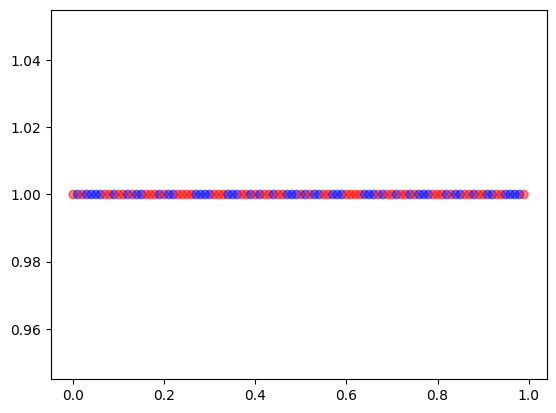

-- Generation 2 --
  Min 47.0
  Max 68.0
  Avg 57.303333333333335
  Std 3.446445834318149


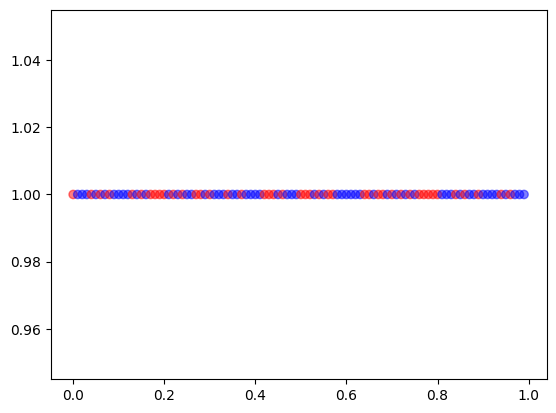

-- Generation 3 --
  Min 52.0
  Max 68.0
  Avg 59.86333333333334
  Std 2.750391891268482


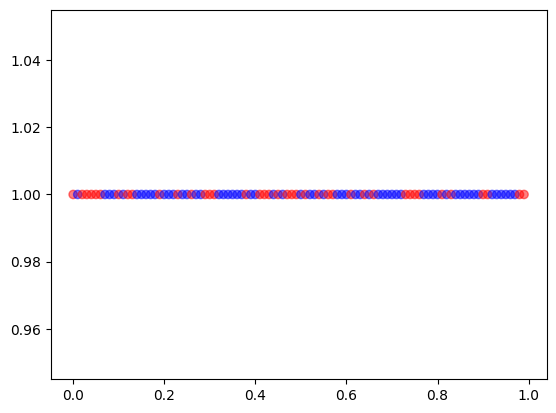

-- Generation 4 --
  Min 54.0
  Max 69.0
  Avg 61.92
  Std 2.6783577057592733


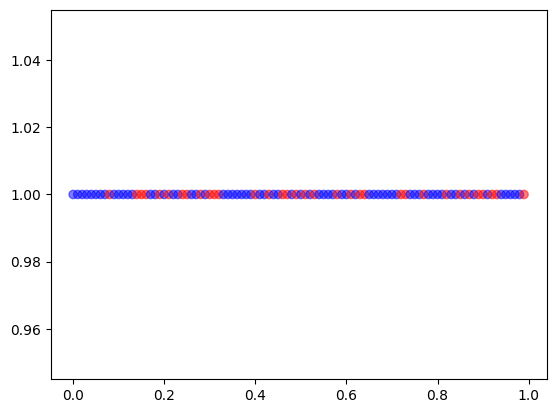

-- Generation 5 --
  Min 56.0
  Max 75.0
  Avg 63.68333333333333
  Std 2.78981281729726


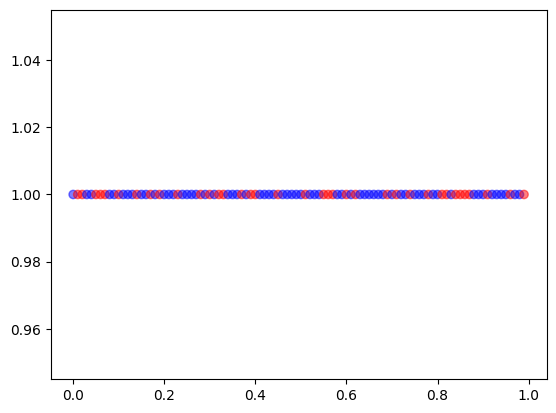

-- Generation 6 --
  Min 57.0
  Max 80.0
  Avg 65.58
  Std 2.965962463237521


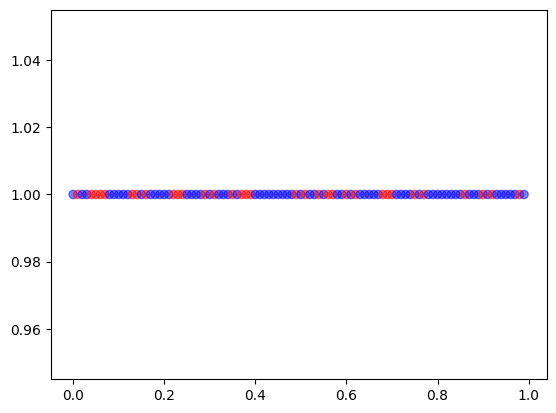

-- Generation 7 --
  Min 59.0
  Max 78.0
  Avg 67.71333333333334
  Std 3.0915727748545816


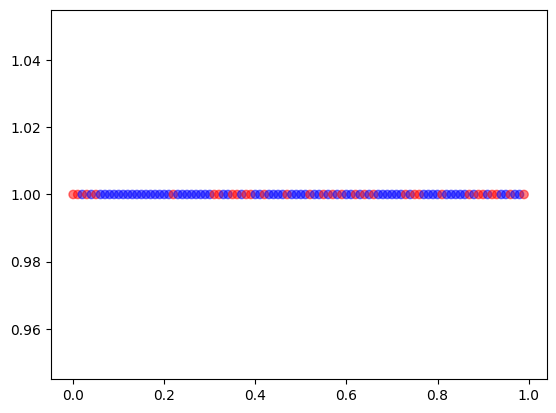

-- Generation 8 --
  Min 60.0
  Max 78.0
  Avg 69.80666666666667
  Std 3.2263429589688872


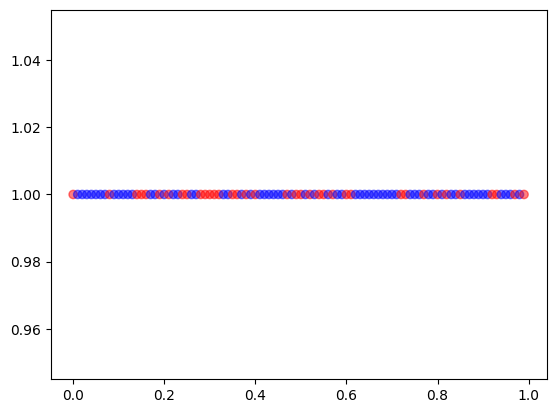

-- Generation 9 --
  Min 63.0
  Max 80.0
  Avg 72.14666666666666
  Std 2.9220692820140735


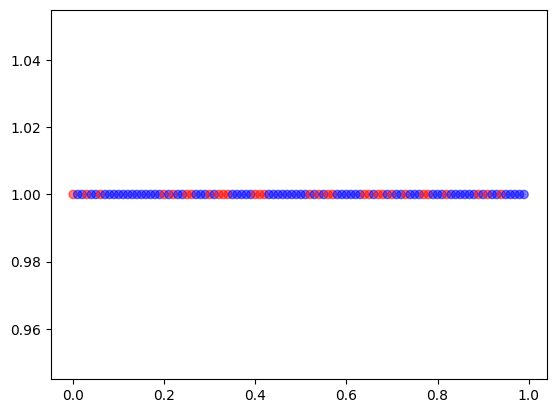

-- Generation 10 --
  Min 62.0
  Max 82.0
  Avg 73.96333333333334
  Std 2.95555785296479


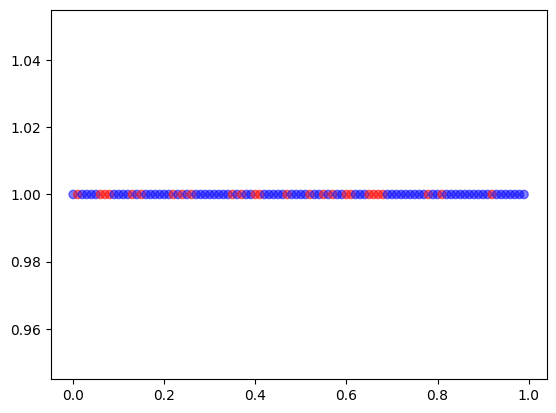

-- Generation 11 --
  Min 62.0
  Max 82.0
  Avg 75.88333333333334
  Std 2.6813657382426332


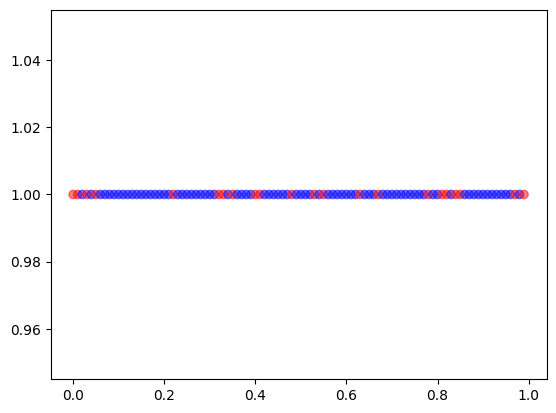

-- Generation 12 --
  Min 68.0
  Max 86.0
  Avg 77.40666666666667
  Std 2.630834257206018


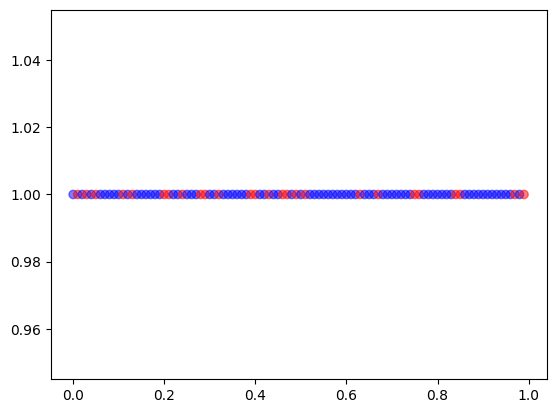

-- Generation 13 --
  Min 69.0
  Max 87.0
  Avg 78.84666666666666
  Std 2.6851112122634717


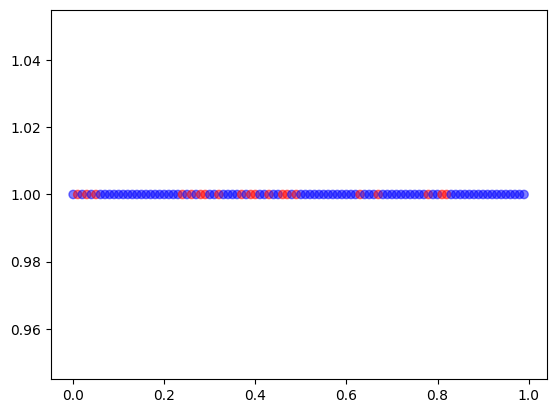

-- Generation 14 --
  Min 71.0
  Max 87.0
  Avg 80.20666666666666
  Std 2.8828149823086417


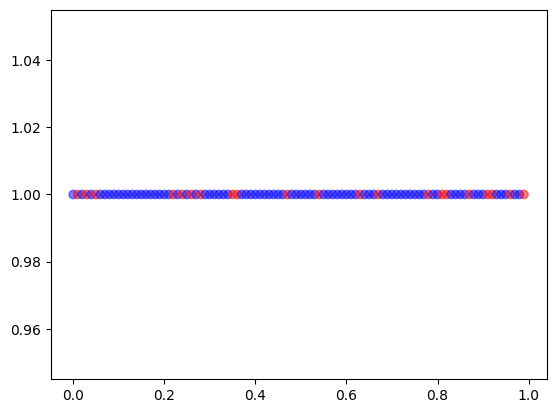

-- Generation 15 --
  Min 74.0
  Max 89.0
  Avg 81.98333333333333
  Std 2.475827583298557


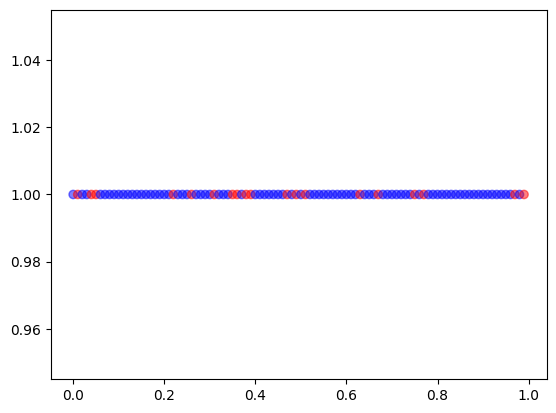

-- Generation 16 --
  Min 74.0
  Max 89.0
  Avg 83.41666666666667
  Std 2.483892554484178


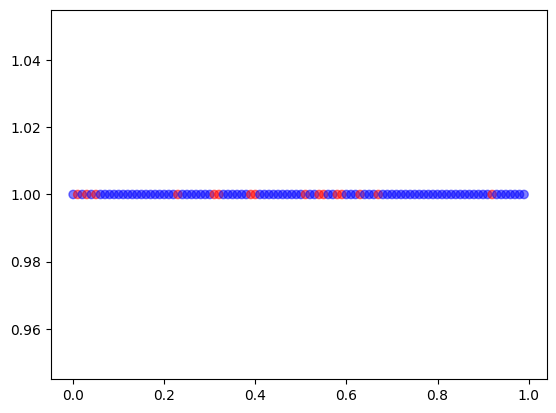

-- Generation 17 --
  Min 74.0
  Max 89.0
  Avg 84.58333333333333
  Std 2.3936838183482663


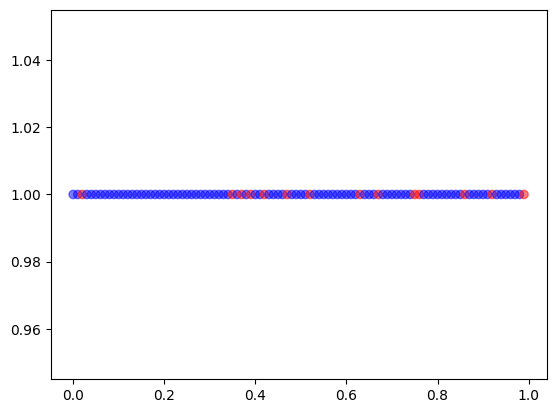

-- Generation 18 --
  Min 76.0
  Max 90.0
  Avg 85.70333333333333
  Std 2.132757734848321


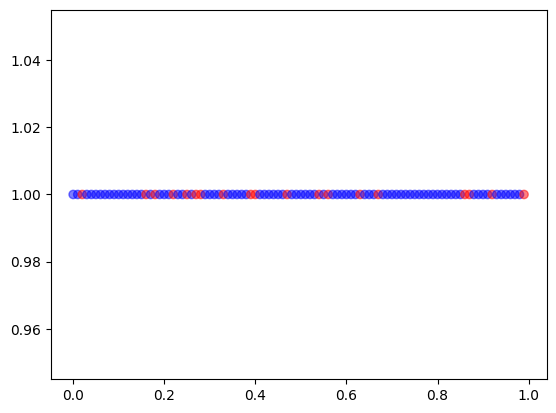

-- Generation 19 --
  Min 77.0
  Max 90.0
  Avg 86.39333333333333
  Std 2.301873632983042


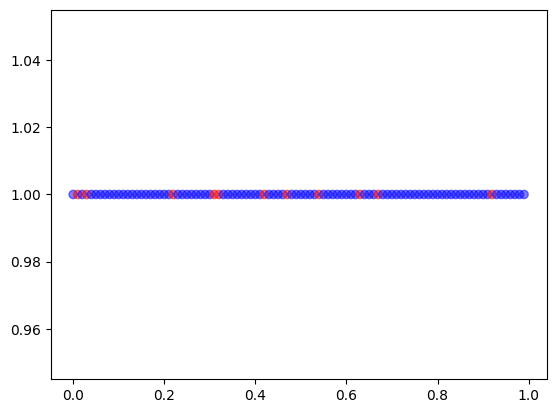

-- Generation 20 --
  Min 75.0
  Max 92.0
  Avg 87.18666666666667
  Std 2.277093664203332


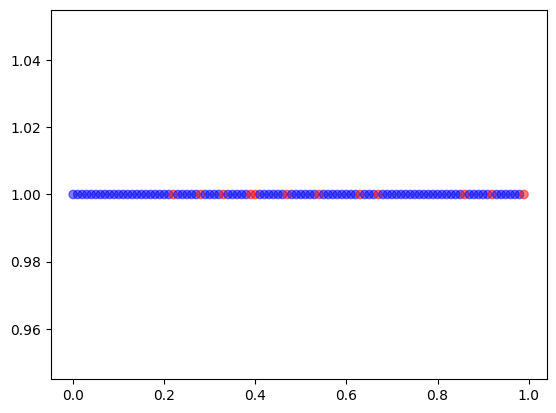

-- Generation 21 --
  Min 80.0
  Max 93.0
  Avg 88.03666666666666
  Std 2.0220424217993584


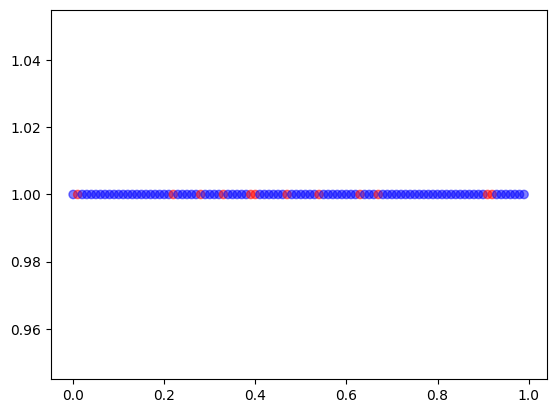

-- Generation 22 --
  Min 78.0
  Max 94.0
  Avg 88.41
  Std 2.5603189905426804


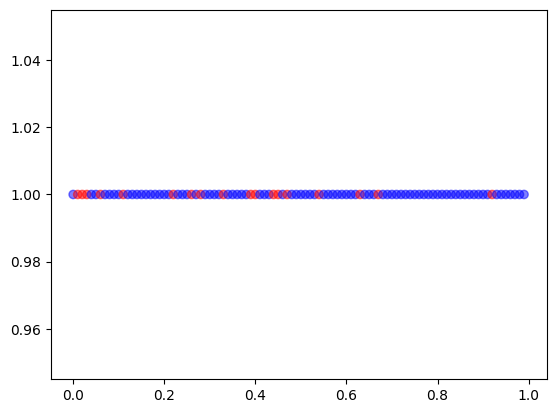

-- Generation 23 --
  Min 81.0
  Max 94.0
  Avg 89.42
  Std 2.2234207878851016


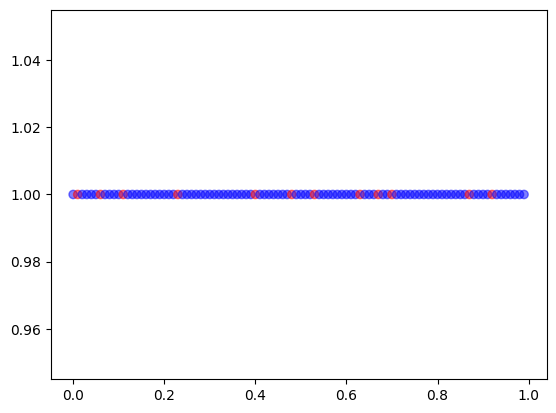

-- Generation 24 --
  Min 82.0
  Max 94.0
  Avg 90.10333333333334
  Std 2.345063372751588


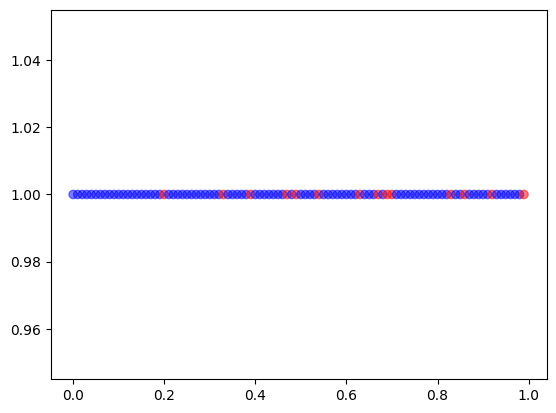

-- Generation 25 --
  Min 79.0
  Max 96.0
  Avg 90.91666666666667
  Std 2.411719073376219


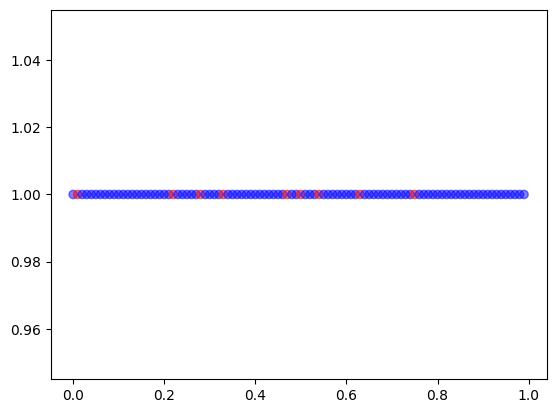

-- Generation 26 --
  Min 80.0
  Max 97.0
  Avg 91.87
  Std 2.315116987684742


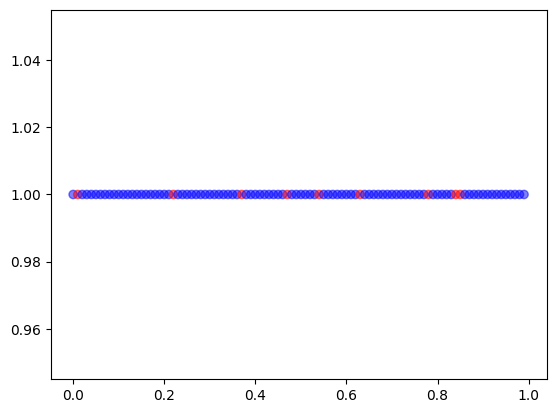

-- Generation 27 --
  Min 82.0
  Max 97.0
  Avg 92.54333333333334
  Std 2.45386543142769


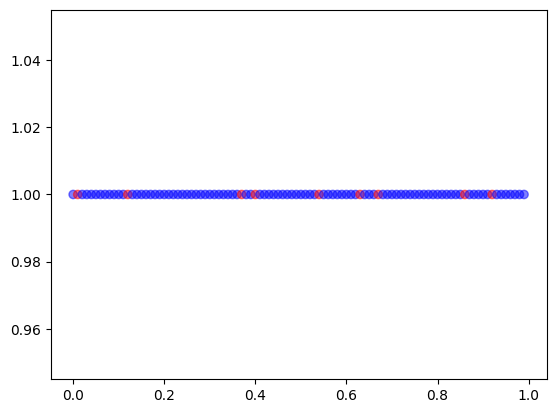

-- Generation 28 --
  Min 85.0
  Max 97.0
  Avg 93.42333333333333
  Std 2.363074739025938


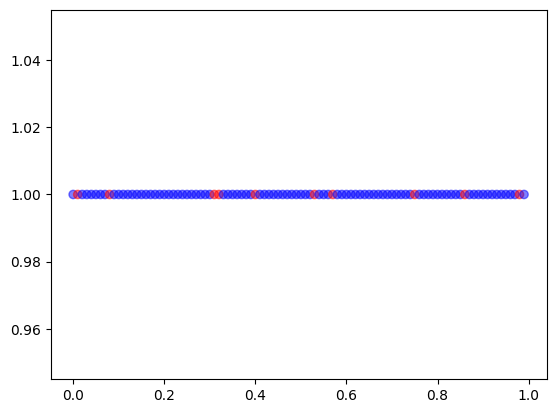

-- Generation 29 --
  Min 86.0
  Max 97.0
  Avg 94.19333333333333
  Std 2.278001073066162


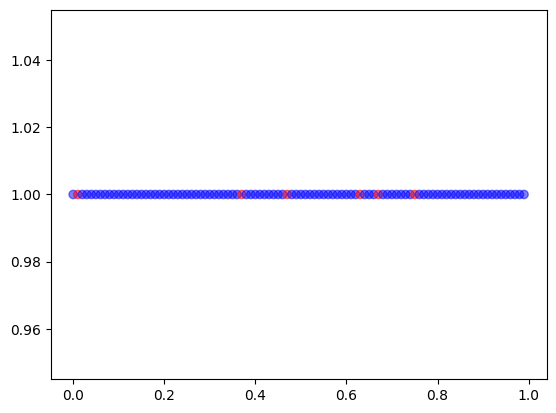

-- Generation 30 --
  Min 86.0
  Max 98.0
  Avg 95.0
  Std 2.2060522810366003


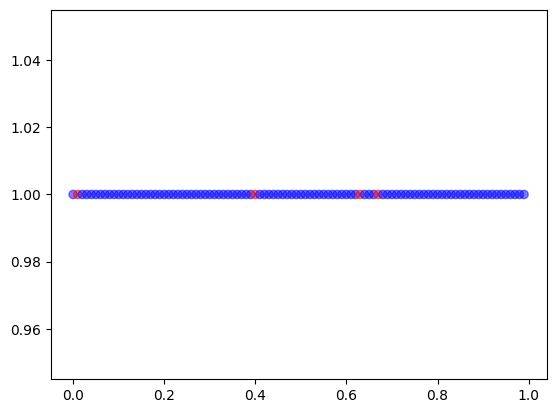

-- Generation 31 --
  Min 88.0
  Max 99.0
  Avg 95.69666666666667
  Std 2.0955481913384353


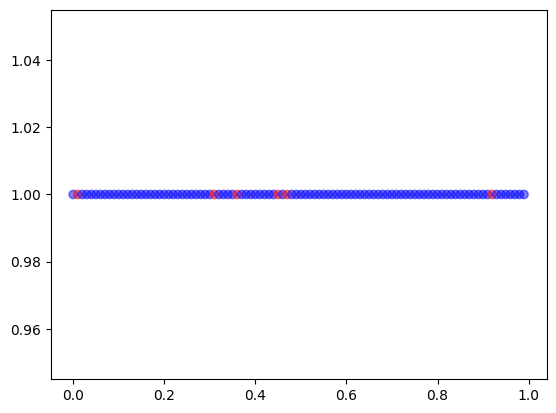

-- Generation 32 --
  Min 83.0
  Max 99.0
  Avg 95.94
  Std 2.4433037742641317


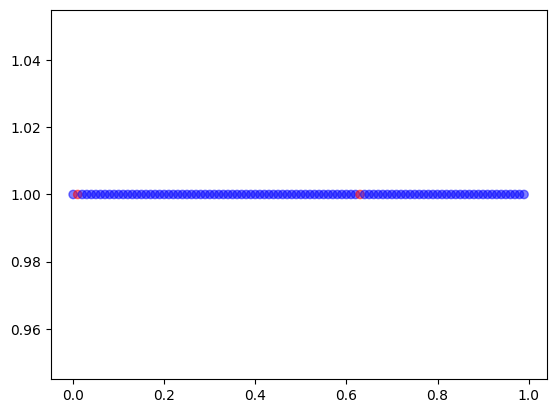

-- Generation 33 --
  Min 87.0
  Max 99.0
  Avg 96.41
  Std 2.3766713417438976


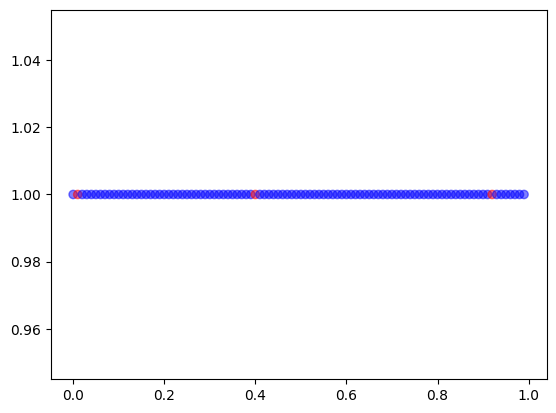

-- Generation 34 --
  Min 86.0
  Max 99.0
  Avg 96.85666666666667
  Std 2.283883145483173


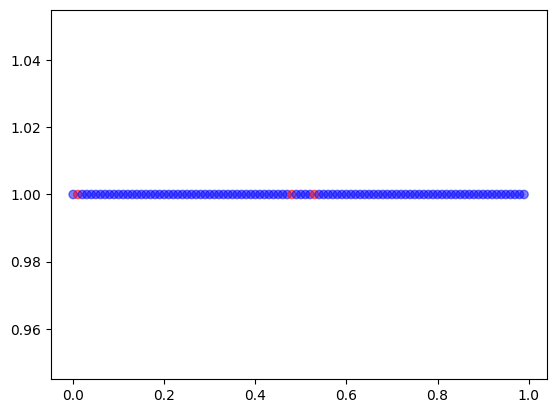

-- Generation 35 --
  Min 87.0
  Max 100.0
  Avg 97.21333333333334
  Std 2.2452517799914387


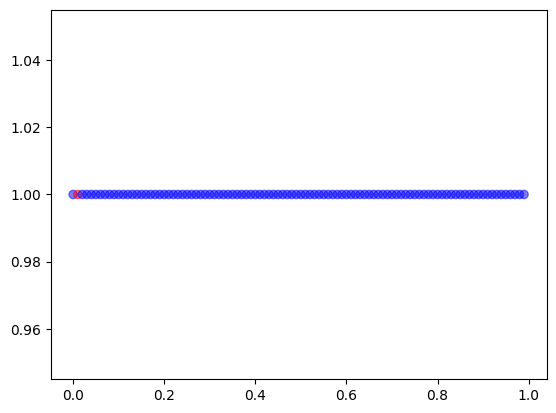

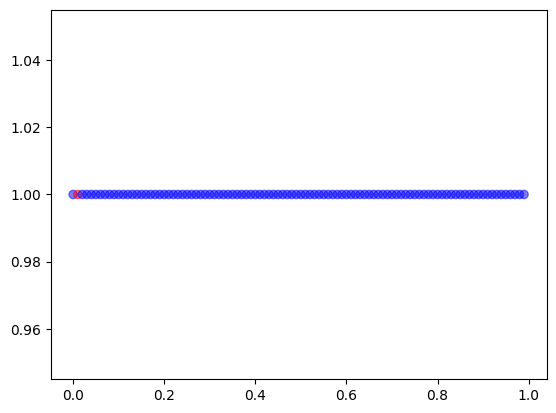

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while max(fits) < 100 and g < 1000:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    mateAndMutate(offspring)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    pop[:] = offspring

    # print statistics on our updated population
    fits=findFitness()

    # plot an arbitrary organism
    x = [i/100 for i in range(len(pop[0]))]
    y = [1 for i in x]
    colors = ['r' if pop[0][i]==0 else 'b' for i in range(len(pop[0]))]
    plt.scatter(x, y, c=colors, alpha=0.5)
    plt.show()
plt.scatter(x,y, c=colors, alpha=.5)
plt.show()

# Your tasks:
This lab *is* fairly open-ended. I look forward to seeing what you come up with:

## 1. Find optimum with ES.
Chose an [artificial landscape](https://en.wikipedia.org/wiki/Test_functions_for_optimization). Find optimum using an evolutionary strategy we talked about in class.

In [12]:
# Your code here
#choose an objective function and try to use this to find the optimum max, the fitness is just y(x) and we can choose x, maybe choose a function with only 1 parameter
#sigma function, add noise taken from a normal(0,1) to x to generate a new population
import math
import random
def sigma(x):
	return (1/(1+math.e**(-x)))

def logit(x):
	return math.log(x/(1-x))

#For instance:

# 0-- initialise population
population=[]
for i in range(100):
	population.append(random.uniform(-50,50))

#for _ in range(num_generations):
num_generations=50
evaluations=[]

for _ in range(num_generations):
	evaluations.clear()

	#1--- evaluation (fitness computation)
	for x in population:
		evaluations.append(sigma(x))

	#2–- selection best,
	#select the best 25 values
	numbest=25
	evaluations.sort(reverse=True)
	#print(evaluations)
	bestY=[evaluations[i] for i in range(numbest)]
	bestX=[]
	for y in bestY:
		epsilon = 1e-15  # Small epsilon to avoid division by zero or one
		bestX = [logit(y) if y > epsilon and y < 1 - epsilon else 1-epsilon for y in bestY]


	#3– create new generation w/ crossover and mating
	#in this example i did not use mating since my function has only one parameter, i only add noise from a normal distribution N(0,1)
	newPool=[]
	newPool.extend(bestX)
	for _ in range(100 - numbest):
		parent = random.choice(bestX)
		mutation = parent + random.gauss(0, 5)
		newPool.append(mutation)
	population=newPool

Xfinal = bestX[0]
Yfinal = bestY[0]

print(f"Best Solution: x = {Xfinal}, sigma(x) = {Yfinal}")


Best Solution: x = 0.999999999999999, sigma(x) = 1.0


## 2. Evolve a simple gaming neural net with GA.
Evolve a neural network that plays a game of your choice from `gym` (LunarLander-v2 is cool).
We don't need `torch` since we don't care about gradients. We can use numpy—numpy matrices can easily be multiplied.
`deap` *can* deal with numpy arrays, though I recommend making functions that map weights to lists and vice versa.



In [13]:
!pip install gym

In [21]:
# Your code here
#neural network is the policy, maybe use DEAP library
import gym
import deap
import numpy as np
import pygame

# 1--Setup Game Environment such as Lunar Lander or another

env = gym.make('CartPole-v1')
observation = env.reset()

# 2---Define your neural net for the agent policy
#You will evolve its weights here.
#The input resp. output dimensions of your network should consider the game state resp. action dimension.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def initializew(input_dim, output_dim, hidden_layer_size=32):
    weights = [np.random.randn(input_dim, hidden_layer_size), np.random.randn(hidden_layer_size, output_dim)]
    return weights

def neural_network(weights, inputs):
    weights=weights
    print("Inputs shape:", inputs.shape)
    print("Weights[0] shape:", weights[0].shape)
    layer1 = sigmoid(np.dot(inputs, weights[0]))
    output = sigmoid(np.dot(layer1, weights[1]))
    return output

def mutate(individual, mutation_rate=0.1):
    # Apply mutation to each weight in the individual
    mutated= [np.copy(w) for w in individual]

    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            noise = np.random.normal(0, 0.1, size=mutated[i].shape)
            mutated[i] += noise
    print("mutation weight", mutated[0].shape)
    return mutated

def crossover(parent1, parent2):
    child1 = [np.copy(p) for p in parent1]
    child2 = [np.copy(p) for p in parent2]
    for i in range(len(parent1)):
        if random.random() < 0.5:
            child1[i], child2[i] = child2[i], child1[i]
    print("cross weight", child1[0].shape)
    print("cross weight", child2[0].shape)
    return child1, child2

# 3--Code an evaluate function (fitness).
# It should take as input an individual, run the game, and for instance return the game score as fitness
# In this evaluation function you should have a loop that runs the game for a certain number of steps, and something like action = policyNN(obs)

def evaluate(individual, max_steps=50):
    env = gym.make('CartPole-v1')

    total_reward = 0
    for _ in range(max_steps):
        observation = env.reset()
        episode_reward = 0
        episode_step=0
        while True:
            action_probabilities = neural_network(individual, observation)
            action = np.argmax(action_probabilities)

            observation, reward, done, _ = env.step(action)
            episode_reward += reward
            episode_step=episode_step+1

            if done:
                break

        total_reward += episode_reward
    fitness = total_reward / episode_step
    env.close()

    return fitness

#4--evolve the neural network: run the evolution loop
population_size=100
population=[]
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

for i in range(population_size):
	population.append(initializew(input_dim, output_dim))

num_generations=50
evaluations=[]
positions=[]
bestW=[]

for _ in range(num_generations):
  evaluations.clear()
  positions.clear()
  bestW.clear()

  #1--evaluation
  for x in population:
    evaluations.append(evaluate(x))
  #2--select the best 25
  numbest=25
  e2=list(evaluations)
  e2.sort(reverse=True)

  for i in range(100):
    if evaluations[i] in e2[:numbest]:
      positions.append(i)

  for i in positions:
    bestW.append(population[i])


  # Create a new population with the selected individuals
  #3– create new generation w/ crossover and mating
  newPool=[]
  CXPB, MUTPB = 0.5, 0.2
  for _ in range(population_size-numbest):
    # Randomly select two parents from the best individuals
    parent1, parent2 = random.choices(bestW, k=2)
    if random.random() < CXPB:
        child1, child2 = crossover(parent1, parent2)
    else:
        # If no crossover, copy parents
        child1, child2 = parent1.copy(), parent2.copy()

    # Perform mutation (you can adjust the mutation rate as needed)
    if random.random() < MUTPB:
       child1= mutate(child1)
    if random.random() < MUTPB:
       child2= mutate(child2)

    # Add the children to the new population
    newPool.extend(child1)
    newPool.extend(child2)
  newPool.extend(bestW)
  population=newPool


bestIndividual=population[0]

print("the best is")
print(bestIndividual)
print("with evaluation")
print(evaluate(bestIndividual))


Streaming output truncated to the last 5000 lines.
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inputs shape: (4,)
Weights[0] shape: (4, 32)
Inpu

KeyboardInterrupt: ignored

## 3. Implement Hebbian Learning on AND and OR logic gates.
Make functions that given an input of the kind `[1,1,0]`, `[0,0,0]`, etc.:
1. Returns 1 if input is all ones, otherwise 0 (AND).
2. Returns 1 if at least one element is 1, otherwise 0 (OR).


Note: XOR is more complex because it is not linearly separable.

In [15]:
import numpy as np
inputs = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1),
          (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]

# targets =
andTargets = [0, 0, 0, 0, 0, 0, 0, 1]
orTargets = [0, 1, 1, 1, 1, 1, 1, 1]

#You can define something like:
def hebbian_learning(inputs, targets, learning_rate=0.0001, epochs=5000, decay_factor=0.001):

    # 1--Initialize weights and bias - One layer can be enough here for AND and OR
    # Your code here
    input_dim = len(inputs[0])
    weights = np.random.rand(input_dim)
    bias = np.random.rand()

    # 2-- Train the network by looping over epochs and over the training data
    for epoch in range(epochs):
        # loop over training data
        for x, y in zip(inputs, targets):
          y_hat = int(np.dot(x, weights) + bias > 0)

	        # Hebbian update to update weights and bias
            # Advise: Calculate before the predicted output of the NN y_hat to use (y- y_hat) to avoid weight explosion
            # Your code here
          deltaW = learning_rate * np.outer(y - y_hat, x)
          weights += deltaW.flatten()
          deltaB = learning_rate * (y - y_hat)
          bias += deltaB

          weights *= (1 - decay_factor)
    return weights, bias


learned_weights_and, learned_bias_and = hebbian_learning(inputs, andTargets)
learned_weights_or, learned_bias_or = hebbian_learning(inputs, orTargets)

print("Learned AND Weights:", learned_weights_and)
print("Learned AND Bias:", learned_bias_and)

print("Learned OR Weights:", learned_weights_or)
print("Learned OR Bias:", learned_bias_or)



Learned AND Weights: [0.00032638 0.00037227 0.00018045]
Learned AND Bias: -0.0007318131109780064
Learned OR Weights: [3.95493649e-18 1.80892040e-18 4.73341659e-19]
Learned OR Bias: 0.1507350641355587


## Optional (and awesome): Do Hebbian Learning over Reinforcement Learning for the Lunar Lander from gym (LunarLander-v2).
![](https://www.gymlibrary.dev/_images/lunar_lander.gif)

In [ ]:
# Your code